<a href="https://colab.research.google.com/github/MoazAshraf/predicting_imdb_ratings/blob/master/predicting_imdb_ratings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Predicting IMDb Ratings for movies, TV shows and games
This solution can be used to develop a movie recommendation system in which movies with higher ratings would have a higher chance of being recommended.

This is a supervised regression problem. [This](https://www.kaggle.com/orgesleka/imdbmovies) public dataset will be used for training and evaluation.

To measure the performance of the system, the root mean squared error will be used as the performance metric. The baseline will be the standard deviation of the movie ratings in the training set as it measures the performance of random guessing.


##Get the Data

In [112]:
import os, stat
from google.colab import files

# upload kaggle.json file
files.upload()  # Upload your kaggle.json file when prompted here

# create the directory
KAGGLE_DIR = '/root/.kaggle'
KAGGLE_FILE_NAME = 'kaggle.json'
if not os.path.isdir(KAGGLE_DIR):
    os.makedirs(KAGGLE_DIR)
kaggle_file_path = os.path.join(KAGGLE_DIR, KAGGLE_FILE_NAME)

# move kaggle file to kaggle directory and set its permissions to be read and written by user only
os.rename(KAGGLE_FILE_NAME, kaggle_file_path)
os.chmod(kaggle_file_path, stat.S_IREAD | stat.S_IWRITE)

Saving kaggle.json to kaggle.json


In [113]:
# download the dataset
!kaggle datasets download -d orgesleka/imdbmovies

imdbmovies.zip: Skipping, found more recently modified local copy (use --force to force download)


In [142]:
# unzip the data
!unzip imdbmovies.zip

Archive:  imdbmovies.zip
replace imdb.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [0]:
import pandas as pd

# read the data
imdb_data = pd.read_csv('imdb.csv', escapechar='\\')

In [116]:
imdb_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14761 entries, 0 to 14760
Data columns (total 44 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   fn                14761 non-null  object 
 1   tid               14761 non-null  object 
 2   title             14761 non-null  object 
 3   wordsInTitle      14748 non-null  object 
 4   url               14761 non-null  object 
 5   imdbRating        13551 non-null  float64
 6   ratingCount       13551 non-null  float64
 7   duration          13745 non-null  float64
 8   year              14731 non-null  float64
 9   type              14761 non-null  object 
 10  nrOfWins          14761 non-null  int64  
 11  nrOfNominations   14761 non-null  int64  
 12  nrOfPhotos        14761 non-null  int64  
 13  nrOfNewsArticles  14761 non-null  int64  
 14  nrOfUserReviews   14761 non-null  int64  
 15  nrOfGenre         14761 non-null  int64  
 16  Action            14761 non-null  int64 

In [141]:
imdb_data.head()

,fn,tid,title,wordsInTitle,url,imdbRating,ratingCount,duration,year,type,nrOfWins,nrOfNominations,nrOfPhotos,nrOfNewsArticles,nrOfUserReviews,nrOfGenre,Action,Adult,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,FilmNoir,GameShow,History,Horror,Music,Musical,Mystery,News,RealityTV,Romance,SciFi,Short,Sport,TalkShow,Thriller,War,Western,imdbRating_cat
0,titles01/tt0012349,tt0012349,Der Vagabund und das Kind (1921),der vagabund und das kind,http://www.imdb.com/title/tt0012349/,8.4,40550.0,3240.0,1921.0,video.movie,1,0,19,96,85,3,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8
1,titles01/tt0015864,tt0015864,Goldrausch (1925),goldrausch,http://www.imdb.com/title/tt0015864/,8.3,45319.0,5700.0,1925.0,video.movie,2,1,35,110,122,3,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8
2,titles01/tt0017136,tt0017136,Metropolis (1927),metropolis,http://www.imdb.com/title/tt0017136/,8.4,81007.0,9180.0,1927.0,video.movie,3,4,67,428,376,2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,8
3,titles01/tt0017925,tt0017925,Der General (1926),der general,http://www.imdb.com/title/tt0017925/,8.3,37521.0,6420.0,1926.0,video.movie,1,1,53,123,219,3,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8
4,titles01/tt0021749,tt0021749,Lichter der Großstadt (1931),lichter der gro stadt,http://www.imdb.com/title/tt0021749/,8.7,70057.0,5220.0,1931.0,video.movie,2,0,38,187,186,3,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,8


In [0]:
# remove records with missing imdb rating
imdb_data.dropna(subset=['imdbRating'], inplace=True)

In [118]:
imdb_data.shape[0]

13551

In [119]:
imdb_data.describe()

,imdbRating,ratingCount,duration,year,nrOfWins,nrOfNominations,nrOfPhotos,nrOfNewsArticles,nrOfUserReviews,nrOfGenre,Action,Adult,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,FilmNoir,GameShow,History,Horror,Music,Musical,Mystery,News,RealityTV,Romance,SciFi,Short,Sport,TalkShow,Thriller,War,Western
count,13551.000000,1.355100e+04,12793.000000,13551.000000,13551.000000,13551.000000,13551.000000,13551.000000,13551.000000,13551.000000,13551.000000,13551.000000,13551.000000,13551.000000,13551.000000,13551.000000,13551.000000,13551.000000,13551.000000,13551.000000,13551.000000,13551.000000,13551.000000,13551.000000,13551.000000,13551.000000,13551.00000,13551.000000,13551.000000,13551.000000,13551.000000,13551.000000,13551.000000,13551.000000,13551.000000,13551.000000,13551.000000,13551.000000
mean,6.865707,2.642480e+04,5626.405378,1989.476496,3.365951,4.914545,25.635377,269.551989,112.456719,2.295107,0.165301,0.001328,0.132610,0.073426,0.044868,0.362630,0.148107,0.075640,0.447495,0.076231,0.061324,0.014021,0.006937,0.041252,0.074312,0.032544,0.02723,0.071877,0.003985,0.006937,0.137702,0.070770,0.034167,0.016899,0.012471,0.096303,0.034831,0.023910
std,1.119515,6.506456e+04,2702.125762,22.302556,9.581572,16.831365,67.742465,1092.792558,236.940988,0.794300,0.371466,0.036423,0.339165,0.260845,0.207021,0.480777,0.355219,0.264431,0.497254,0.265376,0.239932,0.117582,0.083001,0.198879,0.262287,0.177446,0.16276,0.258293,0.063003,0.083001,0.344600,0.256449,0.181665,0.128898,0.110981,0.295017,0.183359,0.152773
min,1.000000,5.000000e+00,2.000000,1888.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.300000,6.025000e+02,4680.000000,1978.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,7.000000,3.977000e+03,5760.000000,1998.000000,0.000000,0.000000,9.000000,13.000000,37.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,7.600000,2.085850e+04,6720.000000,2006.000000,3.000000,4.000000,29.000000,120.500000,114.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,9.900000,1.183395e+06,68400.000000,2014.000000,226.000000,542.000000,2810.000000,32345.000000,4928.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [0]:
from sklearn.model_selection import train_test_split

# split the data into a training set and a test set with stratifying to keep the distributions similar
imdb_data['imdbRating_cat'] = pd.cut(imdb_data['imdbRating'], bins=10, labels=range(10))
training_set, test_set = train_test_split(imdb_data, test_size=0.2, stratify=imdb_data['imdbRating_cat'], random_state=42)

In [121]:
print(training_set.shape, test_set.shape)

(10840, 45) (2711, 45)


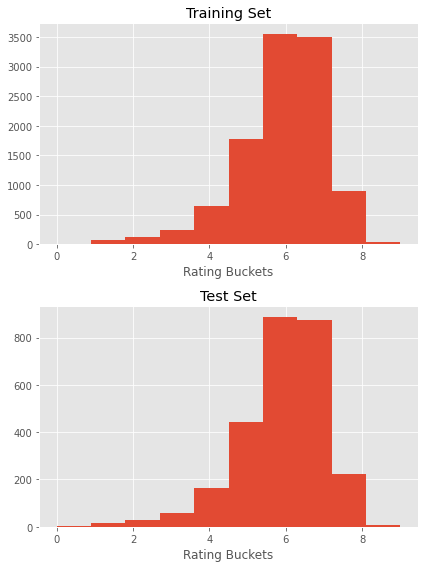

In [122]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')
fig = plt.figure(figsize=(6, 8))

plt.subplot(2, 1, 1)
plt.title('Training Set')
training_set['imdbRating_cat'].hist()
plt.xlabel('Rating Buckets')

plt.subplot(2, 1, 2)
plt.title('Test Set')
test_set['imdbRating_cat'].hist()
plt.xlabel('Rating Buckets')

fig.tight_layout()
plt.show()

In [0]:
training_set = training_set.drop(columns=['imdbRating_cat'])
test_set = test_set.drop(columns=['imdbRating_cat'])

##Explore the Data

In [0]:
# copy the training set for exploration
imdb_train = training_set.copy()

In [125]:
# find featuers that correlate with the IMDb rating
imdb_train.corr()['imdbRating'].sort_values(ascending=False)

imdbRating          1.000000
nrOfWins            0.197543
Drama               0.182356
ratingCount         0.158875
nrOfNominations     0.131055
History             0.088031
nrOfUserReviews     0.085104
Animation           0.079621
nrOfPhotos          0.076881
War                 0.073573
nrOfNewsArticles    0.073354
Biography           0.070995
Documentary         0.058263
FilmNoir            0.044466
Mystery             0.031393
Crime               0.031056
Music               0.024214
duration            0.004470
nrOfGenre           0.004088
GameShow            0.002710
Romance            -0.000913
Musical            -0.001162
Western            -0.004177
Sport              -0.008489
TalkShow           -0.008957
Short              -0.018140
Adult              -0.025073
Comedy             -0.028182
Adventure          -0.038659
RealityTV          -0.043909
News               -0.048069
Family             -0.049218
Fantasy            -0.059329
Thriller           -0.071521
Action        

[]

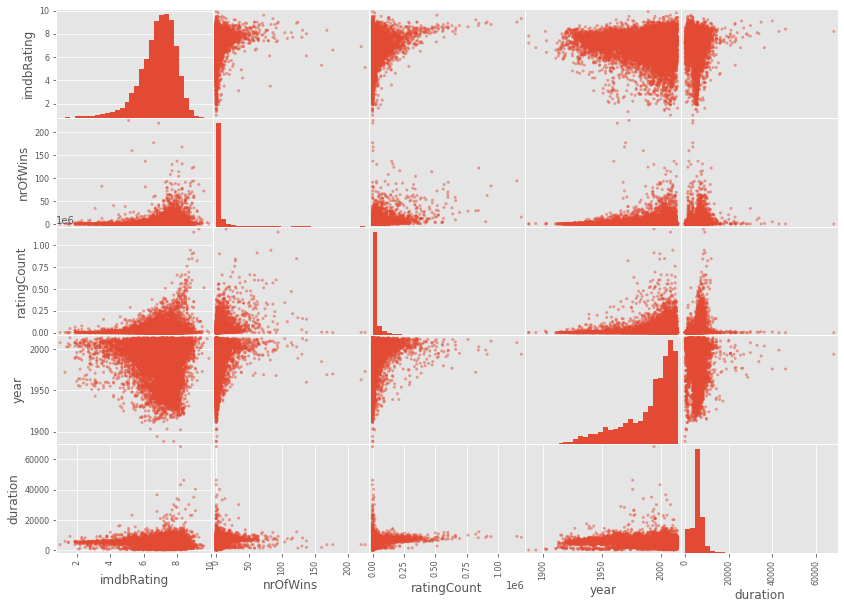

In [126]:
from pandas.plotting import scatter_matrix

# visualize some correlations
features = ['imdbRating', 'nrOfWins', 'ratingCount', 'year', 'duration']
scatter_matrix(imdb_train[features], figsize=(14, 10), hist_kwds={'bins': 30})
plt.plot()

In [0]:
# adding feature combinations
imdb_train['totalNominations'] = imdb_train['nrOfNominations'] + imdb_train['nrOfWins']
imdb_train['winsPerNomination'] = imdb_train['nrOfWins'] / imdb_train['totalNominations']
imdb_train['winsPerNomination'].fillna(0, inplace=True)
imdb_train['reviewsPerRating'] = imdb_train['nrOfUserReviews'] / imdb_train['ratingCount']
imdb_train['reviewsPerRating'].fillna(0, inplace=True)

In [0]:
# add titleWordCount feature, does title length affect rating?
def count(s):
    return len(s.split())

imdb_train['titleWordCount'] = imdb_train['wordsInTitle'].map(count, na_action='ignore')

In [152]:
imdb_train[['winsPerNomination', 'reviewsPerRating', 'totalNominations', 'titleWordCount']].describe()

,winsPerNomination,reviewsPerRating,totalNominations,titleWordCount
count,10840.000000,10840.000000,10840.000000,10830.000000
mean,0.237001,0.011991,8.344373,4.213758
std,0.319922,0.018376,25.767147,2.504666
min,0.000000,0.000000,0.000000,1.000000
25%,0.000000,0.003230,0.000000,2.000000
50%,0.000000,0.006675,0.000000,4.000000
75%,0.441860,0.013717,7.000000,6.000000
max,1.000000,0.333333,768.000000,21.000000


In [153]:
imdb_train.corr()['imdbRating'].sort_values(ascending=False)

imdbRating           1.000000
winsPerNomination    0.209611
nrOfWins             0.197543
Drama                0.182356
totalNominations     0.162485
ratingCount          0.158875
nrOfNominations      0.131055
titleWordCount       0.099090
History              0.088031
nrOfUserReviews      0.085104
Animation            0.079621
nrOfPhotos           0.076881
War                  0.073573
nrOfNewsArticles     0.073354
Biography            0.070995
Documentary          0.058263
FilmNoir             0.044466
Mystery              0.031393
Crime                0.031056
Music                0.024214
duration             0.004470
nrOfGenre            0.004088
GameShow             0.002710
Romance             -0.000913
Musical             -0.001162
Western             -0.004177
Sport               -0.008489
TalkShow            -0.008957
Short               -0.018140
Adult               -0.025073
Comedy              -0.028182
Adventure           -0.038659
RealityTV           -0.043909
News      

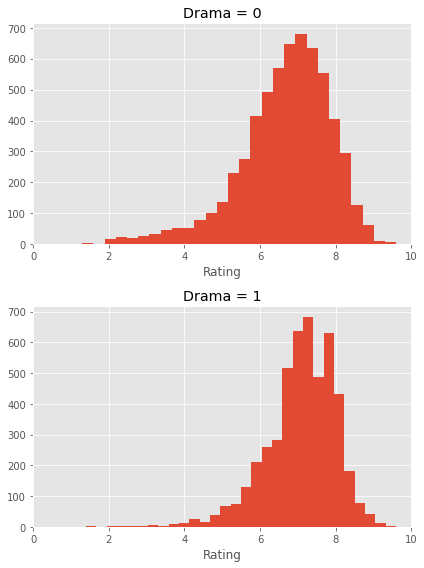

In [154]:
def plot_binary_hists(df, feature):    
    fig = plt.figure(figsize=(6, 8))

    plt.subplot(2, 1, 1)
    plt.title(f"{feature} = 0")
    plt.xlabel('Rating')
    plt.xlim(0, 10)
    df[df[feature]==0]['imdbRating'].hist(bins=30)

    plt.subplot(2, 1, 2)
    plt.title(f"{feature} = 1")
    plt.xlabel('Rating')
    plt.xlim(0, 10)
    df[df[feature]==1]['imdbRating'].hist(bins=30)

    fig.tight_layout()

plot_binary_hists(imdb_train, 'Drama')
plt.show()

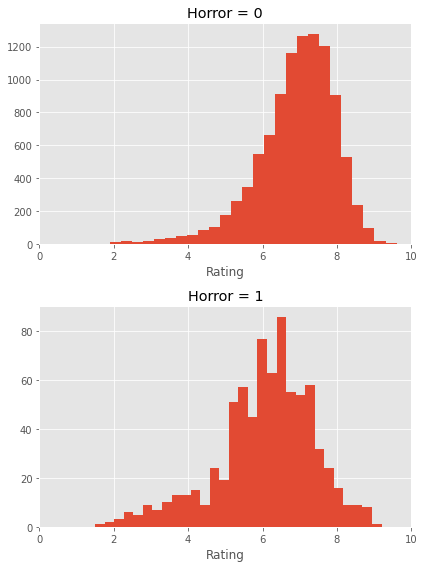

In [155]:
plot_binary_hists(imdb_train, 'Horror')
plt.show()

In [156]:
print(imdb_train['type'].unique())

['video.movie' 'game' 'video.tv' 'video.episode']


In [0]:
# analyze each media type separately
imdb_movies = imdb_train[imdb_train['type']=='video.movie']
imdb_games = imdb_train[imdb_train['type']=='game']
imdb_episodes = imdb_train[imdb_train['type']=='video.episode']
imdb_tv_shows = imdb_train[imdb_train['type']=='video.tv']

In [158]:
# find featuers that correlate with the IMDb rating for movies only
imdb_movies.corr()['imdbRating'].sort_values(ascending=False)

imdbRating           1.000000
winsPerNomination    0.314331
nrOfWins             0.287974
totalNominations     0.278329
Drama                0.248357
nrOfNominations      0.243225
ratingCount          0.213380
duration             0.185504
nrOfUserReviews      0.143836
War                  0.103556
History              0.100450
Biography            0.096981
nrOfNewsArticles     0.096217
nrOfPhotos           0.088006
Documentary          0.084618
FilmNoir             0.069339
Romance              0.048278
Animation            0.046987
Music                0.046450
TalkShow             0.025024
Crime                0.023038
Musical              0.019705
GameShow             0.005981
Western              0.004182
News                 0.003865
RealityTV            0.000126
Sport               -0.001548
Short               -0.001918
Mystery             -0.002329
nrOfGenre           -0.012287
titleWordCount      -0.018844
Adult               -0.024189
Thriller            -0.048815
Adventure 

[]

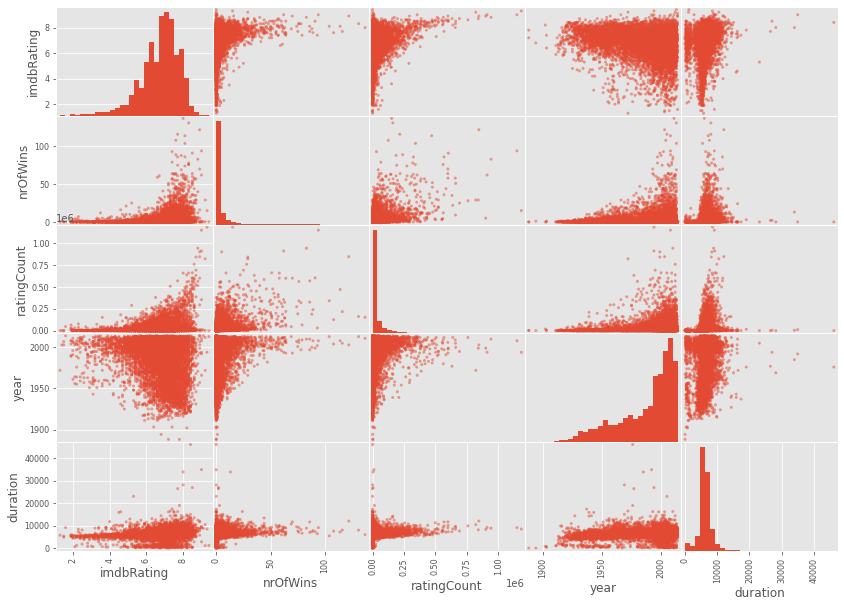

In [159]:
# visualize some correlations for movies only
features = ['imdbRating', 'nrOfWins', 'ratingCount', 'year', 'duration']
scatter_matrix(imdb_movies[features], figsize=(14, 10), hist_kwds={'bins': 30})
plt.plot()

In [160]:
# find featuers that correlate with the IMDb rating for games only
imdb_games.corr()['imdbRating'].sort_values(ascending=False)

imdbRating           1.000000
nrOfUserReviews      0.492883
ratingCount          0.490318
totalNominations     0.364227
nrOfWins             0.342938
nrOfNominations      0.327197
winsPerNomination    0.296019
year                 0.293908
nrOfGenre            0.240210
nrOfPhotos           0.209868
Adventure            0.207499
Comedy               0.180147
History              0.169392
nrOfNewsArticles     0.152663
Drama                0.122095
Fantasy              0.115308
Mystery              0.091536
Horror               0.081203
titleWordCount       0.080934
Animation            0.017469
Sport               -0.001266
Western             -0.001266
Family              -0.001684
Action              -0.004424
War                 -0.026456
Crime               -0.047587
reviewsPerRating    -0.091726
Romance             -0.113940
SciFi               -0.125571
Thriller            -0.181427
duration                  NaN
Adult                     NaN
Biography                 NaN
Documentar

In [161]:
imdb_games.head()

,fn,tid,title,wordsInTitle,url,imdbRating,ratingCount,duration,year,type,nrOfWins,nrOfNominations,nrOfPhotos,nrOfNewsArticles,nrOfUserReviews,nrOfGenre,Action,Adult,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,FilmNoir,GameShow,History,Horror,Music,Musical,Mystery,News,RealityTV,Romance,SciFi,Short,Sport,TalkShow,Thriller,War,Western,totalNominations,winsPerNomination,reviewsPerRating,titleWordCount
7982,titles04/index.html.11856,tt1319708,Deus Ex: Human Revolution (Video Game 2011),deus ex human revolution video game,http://www.imdb.com/title/tt1319708/,8.7,2663.0,NaN,2011.0,game,0,0,0,0,12,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.0,0.004506,6.0
5659,titles03/index.html.5805,tt1525855,La abadía del crimen (Video Game 1987),la abad a del crimen video game,http://www.imdb.com/title/tt1525855/,6.8,6.0,NaN,1987.0,game,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.000000,7.0
4332,titles03/index.html.4270,tt0450955,50 Cent: Bulletproof (Video Game 2005),cent bulletproof video game,http://www.imdb.com/title/tt0450955/,3.4,389.0,NaN,2005.0,game,0,0,0,0,7,3,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.0,0.017995,4.0
3360,titles03/index.html.3029,tt0185037,The Legend of Zelda 2: Rinku no bôken (Video G...,the legend of zelda rinku no b ken video game,http://www.imdb.com/title/tt0185037/,7.3,519.0,NaN,1987.0,game,0,0,0,0,15,3,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.028902,10.0
14174,titles04/index.html.8951,tt0421136,Leisure Suit Larry: Magna Cum Laude (Video Gam...,leisure suit larry magna cum laude video game,http://www.imdb.com/title/tt0421136/,6.5,150.0,NaN,2004.0,game,0,0,0,0,1,3,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0.0,0.006667,8.0


In [0]:
# duration should be filled with 0 for games so that models learn to ignore it
imdb_train.loc[imdb_train['type']=='game', 'duration'].fillna(0, inplace=True)

In [163]:
# find featuers that correlate with the IMDb rating for TV shows only
imdb_tv_shows.corr()['imdbRating'].sort_values(ascending=False)

imdbRating           1.000000
ratingCount          0.311762
nrOfUserReviews      0.293095
nrOfGenre            0.228716
Drama                0.176863
Crime                0.146109
Mystery              0.133434
Comedy               0.125068
nrOfPhotos           0.115791
History              0.106833
winsPerNomination    0.098696
Action               0.097240
Thriller             0.090489
Animation            0.085817
War                  0.073329
Adventure            0.066001
nrOfWins             0.057945
Western              0.056478
Biography            0.056026
totalNominations     0.052442
Fantasy              0.052168
nrOfNominations      0.048863
SciFi                0.040451
nrOfNewsArticles     0.037501
duration             0.027023
Horror               0.025253
Sport                0.014734
Musical              0.004358
year                 0.001693
Short                0.001345
Documentary         -0.000930
titleWordCount      -0.041163
Romance             -0.044357
Music     

In [164]:
# find featuers that correlate with the IMDb rating for episodes only
imdb_episodes.corr()['imdbRating'].sort_values(ascending=False)

imdbRating           1.000000
Drama                0.222867
ratingCount          0.217766
nrOfPhotos           0.178619
Mystery              0.166849
SciFi                0.133270
nrOfUserReviews      0.124227
Horror               0.121992
Fantasy              0.095144
nrOfGenre            0.088180
Crime                0.087010
Action               0.053573
Sport                0.039736
History              0.037880
Adventure            0.033893
duration             0.032605
nrOfNominations      0.029857
totalNominations     0.028363
nrOfNewsArticles     0.020617
reviewsPerRating     0.020225
nrOfWins             0.017560
winsPerNomination    0.016646
Biography            0.015000
Comedy               0.004310
Western              0.001569
Romance              0.001230
Thriller            -0.001016
War                 -0.010081
Short               -0.026395
year                -0.027166
Family              -0.029292
Musical             -0.038319
GameShow            -0.039009
Documentar

Notes about the data so far:
- There are 4 types of media: movies, TV shows, TV episodes and games
- For movies:
  - Rating positively correlates with the ratio of wins to total nominations
  - Rating positively correlates with the duration, it seems longer movies are rated higher
  - Rating negatively correlates with the year, it seems old movies are rated higher than new movies
  - Rating negatively correlates with the ratio of user reviews to user ratings, people seem to review movies they dislike more than movies they like
  - Drama movies tend to get higher ratings
  - Horror movies tend to get lower ratings
- For games:
  - Duration should be set to 0 for games so that models learn to ignore it
  - Rating positively correlates with the ratio of wins to total nominations
  - Rating positively correlates with the year, it seems new games are rated higher than old games
  - Adventure games tend to get higher ratings
  - Thriller games tend to get lower ratings
- For TV shows:
  - Duration does not seem to affect rating
  - Year of release does not seem to affect rating
  - Drama shows tend to have higher ratings
  - Reality TV shows tend to have lower ratings
- For TV episodes:
  - Duration does not seem to affect rating
  - Year of release does not seem to affect rating
  - Episodes with the Drama genre tend to have higher ratings
  - Episodes with the News genre tend to have lower ratings
- Title word count is a useless feature

##Prepare the Data

1. Data cleaning:
    - Fix or remove outliers
    - Fill in missing duration with median for each media type except for games, fill with zero
2. Feature selection:
    - Drop nominal features (e.g. id, title, etc.)
    - Drop features that provide no useful information (e.g. after using a decision tree model to find feature importances)
3. Feature engineering:
    - Convert media type to one-hot encoded features
    - Add winsPerNomination, reviewsPerRating and totalNominations
4. Feature scaling:
    - Standardize or normalize features

In [0]:
# copy training set again
imdb_train = training_set.copy()

In [0]:
def drop_missing_rating(df):
    return df.dropna(subset=['imdbRating'])

imdb_train = drop_missing_rating(imdb_train)

In [0]:
def separate_features_targets(df, target_column='imdbRating'):
    feature_columns = list(df.columns)
    feature_columns.remove(target_column)
    X = df[feature_columns].copy()
    y = df[target_column].copy()
    return X, y

train_X, train_y = separate_features_targets(imdb_train)

In [0]:
nominal_columns = ['fn', 'tid', 'title', 'wordsInTitle', 'url']

def drop_nominal(df):
    return df.drop(columns=nominal_columns)

train_X = drop_nominal(train_X)

In [0]:
def encode_type_one_hot(df):
    df = pd.concat([df, pd.get_dummies(df['type'])], axis=1)
    df = df.drop(columns=['type'])
    return df

train_X = encode_type_one_hot(train_X)

In [0]:
def add_feature_combinations(df):
    df = df.copy()
    df['totalNominations'] = df['nrOfNominations'] + df['nrOfWins']
    df['winsPerNomination'] = df['nrOfWins'] / df['totalNominations']
    df['winsPerNomination'] = df['winsPerNomination'].fillna(0)
    df['reviewsPerRating'] = df['nrOfUserReviews'] / df['ratingCount']
    df['winsPerNomination'] = df['reviewsPerRating'].fillna(0)
    return df

train_X = add_feature_combinations(train_X)

In [0]:
def basic_preprocess(df):
    df = drop_nominal(df)
    df = encode_type_one_hot(df)
    df = add_feature_combinations(df)
    return df

In [0]:
feature_columns = list(train_X.columns)

In [0]:
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin

class DurationImputer(BaseEstimator, TransformerMixin):
    def __init__(self, columns=feature_columns):
        self.columns = columns
    
    def fit(self, X, y=None):
        X = pd.DataFrame(X, columns=self.columns)
        X_movies = X[X['video.movie'] == 1]
        self.movie_duration_median = X_movies['duration'].median()

        X_tv_shows = X[X['video.tv'] == 1]
        self.tv_show_duration_median = X_tv_shows['duration'].median()
        
        X_episodes = X[X['video.episode'] == 1]
        self.episode_duration_median = X_episodes['duration'].median()
        return self
    
    def transform(self, X):
        X = pd.DataFrame(X, columns=self.columns)
        X[X['game'] == 1] = 0

        movies_condition = X['video.movie'] == 1
        X[movies_condition] = X[movies_condition].fillna(self.movie_duration_median)

        tv_shows_condition = X['video.tv'] == 1
        X[tv_shows_condition] = X[tv_shows_condition].fillna(self.tv_show_duration_median)

        episodes_condition = X['video.episode'] == 1
        X[episodes_condition] = X[episodes_condition].fillna(self.episode_duration_median)

        return X

In [0]:
duration_imputer = DurationImputer()
train_X = duration_imputer.fit_transform(train_X)

In [320]:
train_X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10840 entries, 11613 to 14254
Data columns (total 44 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ratingCount        10840 non-null  float64
 1   duration           10840 non-null  float64
 2   year               10840 non-null  float64
 3   nrOfWins           10840 non-null  int64  
 4   nrOfNominations    10840 non-null  int64  
 5   nrOfPhotos         10840 non-null  int64  
 6   nrOfNewsArticles   10840 non-null  int64  
 7   nrOfUserReviews    10840 non-null  int64  
 8   nrOfGenre          10840 non-null  int64  
 9   Action             10840 non-null  int64  
 10  Adult              10840 non-null  int64  
 11  Adventure          10840 non-null  int64  
 12  Animation          10840 non-null  int64  
 13  Biography          10840 non-null  int64  
 14  Comedy             10840 non-null  int64  
 15  Crime              10840 non-null  int64  
 16  Documentary       

In [0]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

std_scale_columns = [
    'ratingCount',
    'duration',
    'year',
    'nrOfWins',
    'nrOfNominations',
    'nrOfPhotos',
    'nrOfNewsArticles',
    'nrOfUserReviews',
    'nrOfGenre',
    'totalNominations',
    'winsPerNomination',
    'reviewsPerRating'
]

feature_preprocessing_pipeline = Pipeline([
                                   ('basic_preprocess', FunctionTransformer(basic_preprocess)),
                                   ('duration_imputer', DurationImputer()),
                                   ('std_scaler', ColumnTransformer([('std_scaler', StandardScaler(), std_scale_columns)], remainder='passthrough'))
])

In [0]:
# fit the preprocessing pipeline on the training set
train_X, train_y = separate_features_targets(training_set)
train_X = feature_preprocessing_pipeline.fit_transform(train_X)